# Imports

In [2]:

import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
from gensim.models import FastText
import re
import nltk
import contractions
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

2024-10-08 11:33:46.653078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


# Variaveis onde está os ficheiros de treino e o modelo

In [5]:
#file onde já está o modelo treinado"
model=None
newPKL = "joao3"


#limpesa de ficheiro de treino
data="train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [6]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
df = read_file_to_dataframe(data+".txt")
print(df)

Data to DataFrame

                              0          1        2                        3  \
0                  Ela Cheppanu     Telugu  romance                   Ramana   
1     A Nightmare on Elm Street   American   horror             Samuel Bayer   
2               American Gothic   American   horror               John Hough   
3                          Gang  Bollywood    crime              Mazhar Khan   
4            Intimate Relations    British    drama            Charles Frank   
...                         ...        ...      ...                      ...   
8036              Sa 'Yo Lamang   Filipino    drama          Laurice Guillen   
8037          The Lemon Sisters   American    drama             Joyce Chopra   
8038      Dil Ne Phir Yaad Kiya  Bollywood  romance                  Unknown   
8039  Rehnaa Hai Terre Dil Mein  Bollywood  romance            Gautham Menon   
8040             Things to Come    British   sci-fi  William Cameron Menzies   

                    

8041
Average word count: 370.33


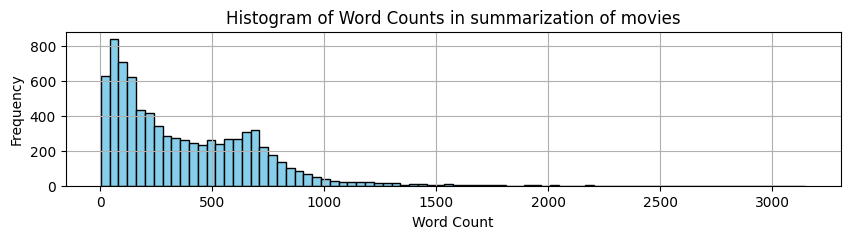

In [7]:
# histogram of word count
print(len(df))

df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [ ]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

## Pre Processamento

In [9]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [10]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [11]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [12]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [13]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [14]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [ ]:
def remove_references(text):
    # Substituir ".[\d]" por "."
    text = re.sub(r'\.\[\d+\]', '.', text)
    
    return text

In [ ]:
print("\033[34mPre Processing the data\n\033[0m")
def preprocess_text(text):
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    text = remove_references(text)         # Step 7: Remove references
    
    return text

# Example usage

# df.iloc[:, 4] = df.iloc[:, 4].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

In [ ]:
# histogram of word count after pre-processing
df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

In [ ]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'

In [1]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

 (100.00%) [==================================================>]                                                 ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]> 

In [11]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to convert a sentence to fastText embeddings
def sentence_to_embedding(sentence, model, max_len):
    embeddings = []
    words = sentence.split()  # Basic tokenization; you can use nltk or spacy for better tokenization
    for word in words:
        embeddings.append(model.get_word_vector(word))  # Get the FastText embedding of the word
    # Padding or truncating the sequence to a fixed length
    embeddings = pad_sequences([embeddings], maxlen=max_len, dtype='float32', padding='post', truncating='post')
    return embeddings[0]


In [12]:
X = df.iloc[:, 4]  # Movie plots
y = df.iloc[:, 2]  # Genres (labels)

# Convert genres to one-hot encoding (if they are not already)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
max_len = 300  # Maximum length of the sequence

# Embed training data
X_train_embeddings = np.array([sentence_to_embedding(plot, ft, max_len) for plot in X_train])

# Embed testing data
X_test_embeddings = np.array([sentence_to_embedding(plot, ft, max_len) for plot in X_test])


In [14]:
from keras.layers import LSTM, Dense, Dropout, Masking

# Define the LSTM model
model = Sequential()

# Masking layer to ignore padding (0 values)
model.add(Masking(mask_value=0., input_shape=(max_len, 300)))

# LSTM layer
model.add(LSTM(units=128, return_sequences=False))

# Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# **Add a hidden Dense layer with ReLU activation**
model.add(Dense(64, activation='relu'))  # Hidden layer with 64 units

# Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Output layer for 9 genres (using softmax for multiclass classification)
model.add(Dense(9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

2024-10-08 12:00:30.363011: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 228,489
Trainable params: 228,489
Non-trai

: 

In [10]:
# Train the model on the training data
model.fit(X_train_embeddings, y_train, epochs=10, batch_size=32, validation_split=0.2)

AttributeError: 'NoneType' object has no attribute 'fit'

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test_embeddings, y_test)

print(f'Test Accuracy: {test_acc}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict genres on the test data
y_pred = model.predict(X_test_embeddings)

# Convert predictions and true labels back to class labels (from one-hot encoding)
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.show()

# Optionally, calculate accuracy
print(f'Confusion Matrix Accuracy: {accuracy_score(y_test_classes, y_pred_classes)}')
